In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'MMD-MA'
modality_names = ['Modality 1', 'Modality 2']
data1 = np.loadtxt("../data/Unioncom/MMD/s1_mapped1.txt")
data2 = np.loadtxt("../data/Unioncom/MMD/s1_mapped2.txt")
type1 = np.loadtxt("../data/Unioncom/MMD/s1_type1.txt")
type2 = np.loadtxt("../data/Unioncom/MMD/s1_type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)
type1 = np.array([f'Cell Type {i}' for i in type1])
type2 = np.array([f'Cell Type {i}' for i in type2])

# Labels
labels = [type1, type2]
features = [None, None]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

In [5]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [279]:
# # Reduced Priors
# full_priors = np.eye(len(dataset[0]))

# random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
# priors = np.zeros(len(dataset[0]))
# priors[random_idx] = 1
# half_priors = np.diag(priors)

# none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 128
pca_dim = [128, 128]
dist_method = 'euclidean'

# ComManDo

In [364]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2500,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
    'loss_weights': [1,1,1,1],
}
fromChar = [' ', '),', '(', ')', ',', '\'', '[', ']']
toChar = ['', '--', '', '', '-', '', '(', ')']
kwargs_str = str(sorted(kwargs.items()))[1:-1]
for f, t in zip(fromChar, toChar):
    kwargs_str = kwargs_str.replace(f, t)
hash_str = '---'.join([dataset_name, '-'.join([str(s) for s in dataset[0].shape]), '-'.join([str(s) for s in dataset[1].shape]), kwargs_str])

In [369]:
# Integration
cm = ComManDo(**kwargs)  # , match_result=cm.match_result, debug=True)
model_str = 'saved_models/cm---' + hash_str + '.h5'
try:
    # raise FileNotFoundError()
    cm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_data = cm.fit_transform(dataset=dataset)
    cm.save_model(model_str)
cm_data = cm.transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
---------------------------------
Train coupled autoencoders
[tensor(0.0005), tensor(1.5470), tensor(0.4654), tensor(0.0178)]
[tensor(0.0010), tensor(1.7531), tensor(0.1932), tensor(0.0104)]
[tensor(0.0014), tensor(1.5621), tensor(0.1365), tensor(0.0072)]
[tensor(0.0019), tensor(1.5184), tensor(0.0969), tensor(0.0035)]
epoch:[500/5000]: loss:1.611240
[tensor(0.0025), tensor(1.5685), tensor(0.0850), tensor(0.0011)]
[tensor(0.0032), tensor(1.3925), tensor(0.0862), tensor(0.0021)]
[tensor(0.0039), tensor(1.2618), tensor(0.0828), tensor(0.0013)]
[tensor(0.0050), tensor(1.2925), tensor(0.0637), tensor(0.0015)]
[tensor(0.0062), tensor(1.3532), tensor(0.0677), tensor(0.0017)]
epoch:[1000/5000]: loss:1.416312
[tensor(0.0078), tensor(1.4605), tensor(0.0645), tensor(0.0006)]
[tensor(0.0096), tensor(1.3255), tensor(0.0524), tensor(0.0020)]
[tensor(0.0115), tensor(1.0975), tensor(0.0621), tensor(0.0011)]
[tensor(0

In [226]:
# Imputation
cm_im = ComManDo(**kwargs)
model_str = 'saved_models/cm_im---' + hash_str + '.h5'
try:
    # raise FileNotFoundError()
    cm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
    cm_im.save_model(model_str)
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (240, 2000)
Dataset 1: (240, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:3.8125 alpha:0.3419
epoch:[1000/2000] err:3.3771 alpha:0.3700
epoch:[1500/2000] err:3.4133 alpha:0.3796
epoch:[2000/2000] err:3.4500 alpha:0.3852
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2500]: loss:0.711201
epoch:[1000/2500]: loss:0.668038
epoch:[1500/2500]: loss:0.650841
epoch:[2000/2500]: loss:0.648628
epoch:[2500/2500]: loss:0.681547
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.062469983007758856
Correspondence: 8.596095156972297
Mapping: 49.14816967799561
Total: 57.806734817975666



# Comparison Methods

In [10]:
integrated_data = [cm_data]
integrated_names = ['JAMIE']
colors = ['blue']

In [11]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
integrated_data.append(nlma_data)
integrated_names.append('NLMA')
colors.append('red')

In [12]:
# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
integrated_data.append(lma_data)
integrated_names.append('LMA')
colors.append('orange')

In [13]:
# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
integrated_data.append(cca_data)
integrated_names.append('CCA')
colors.append('m')

In [15]:
# # MMD-MA
# from sklearn.metrics import pairwise_distances
# mmd_ma_data, _, _ = mmd_combine(pairwise_distances(dataset[0]), pairwise_distances(dataset[1]), method='mmd_ma', p=reduced_dim)
# integrated_data.append(mmd_ma_data)
# integrated_names.append('MMD-MA')
# colors.append('yellow')

In [16]:
# UnionCom
uc_data, _, _ = mmd_combine(*dataset, method='unioncom', output_dim=reduced_dim)
integrated_data.append(uc_data)
integrated_names.append('Unioncom')
colors.append('green')

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:18.2463 alpha:0.7467
epoch:[200/2000] err:7.6079 alpha:0.3344
epoch:[300/2000] err:5.7874 alpha:0.3945
epoch:[400/2000] err:4.4548 alpha:0.4520
epoch:[500/2000] err:3.8050 alpha:0.4898
epoch:[600/2000] err:3.4400 alpha:0.5147
epoch:[700/2000] err:3.2158 alpha:0.5321
epoch:[800/2000] err:3.0627 alpha:0.5454
epoch:[900/2000] err:2.9598 alpha:0.5564
epoch:[1000/2000] err:2.8918 alpha:0.5652
epoch:[1100/2000] err:2.8472 alpha:0.5728
epoch:[1200/2000] err:2.8168 alpha:0.5792
epoch:[1300/2000] err:2.7948 alpha:0.5847
epoch:[1400/2000] err:2.7798 alpha:0.5896
epoch:[1500/2000] err:2.7699 alpha:0.5940
epoch:[1600/2000] err:2.7644 alpha:0.5981
epoch:[1700/2000] err:2.7610 alpha:0.6018
epoch:[1800/2000] err:2.7583 alpha:0.6051
epoch:[1900/2000] err:2.7568 alpha:0.6081
epoch:[2000/2000] err:2

In [17]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'Dual Autoencoder'
    nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]

200/200 [|||||||||||||||||||||||||]: - 7/7 (++++++++++) - Loss: 0.0954
Done!
200/200 [|||||||||||||||||||||||||]: - 7/7 (++++++++++) - Loss: 0.0592
Done!


# Visualization

In [371]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [372]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], color=c, lw=5, label=n) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('./output_figures/' + dataset_name + '-labelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('./output_figures/' + dataset_name + '-algorithmLegend.png', bbox_inches=bbox, dpi=300)

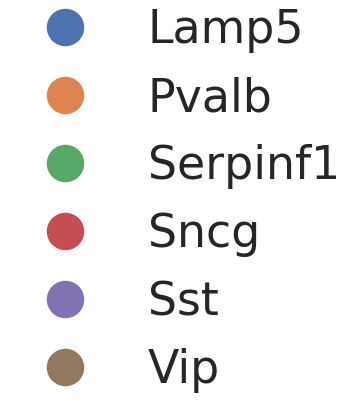

In [70]:
from IPython.display import Image
display(Image(filename='./output_figures/' + dataset_name + '-labelLegend.png', width=100))

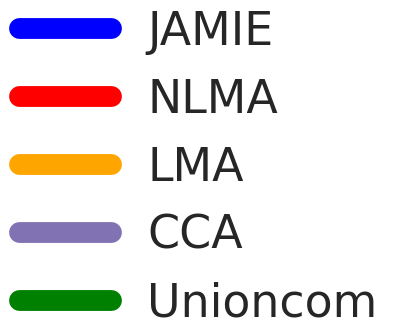

In [71]:
from IPython.display import Image
display(Image(filename='./output_figures/' + dataset_name + '-algorithmLegend.png', width=100))

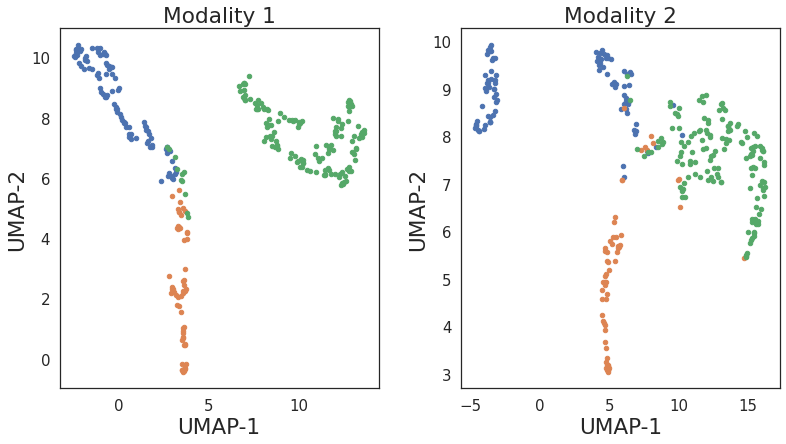

In [373]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Data.png', dpi=300)

In [ ]:
# fig = plt.figure(figsize=(10, 5))
# plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
# plt.tight_layout()
# plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
# plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png', dpi=300)

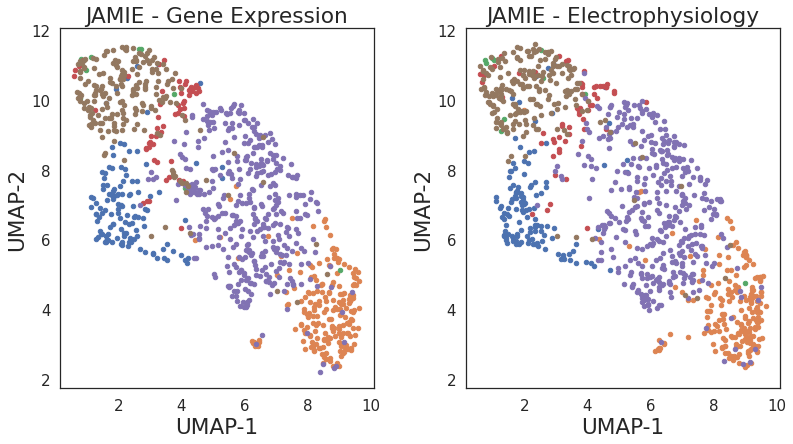

None

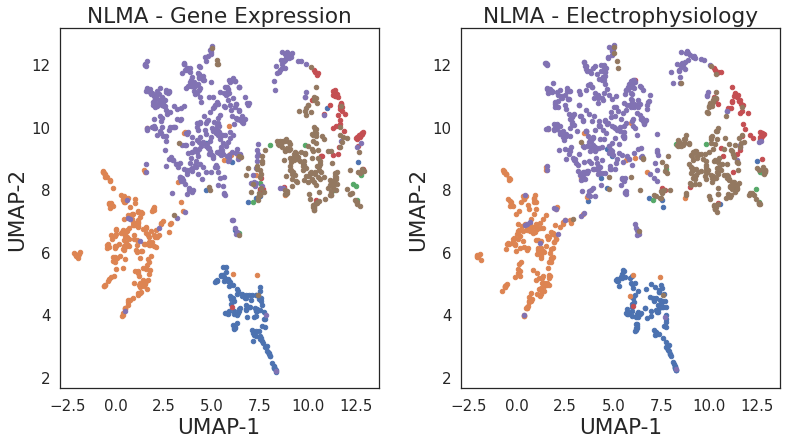

None

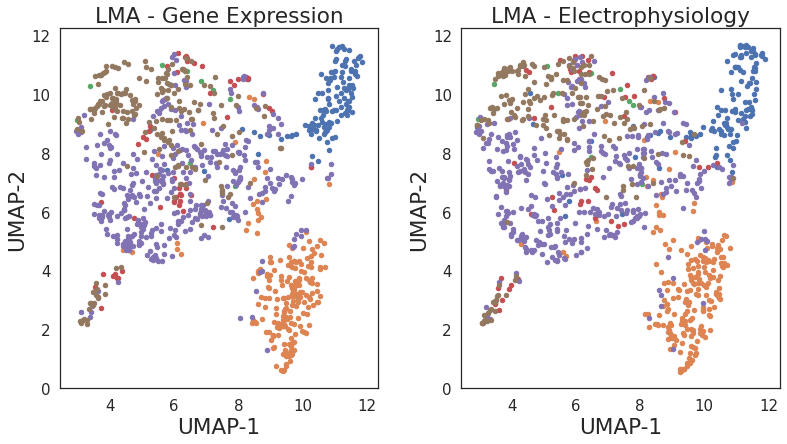

None

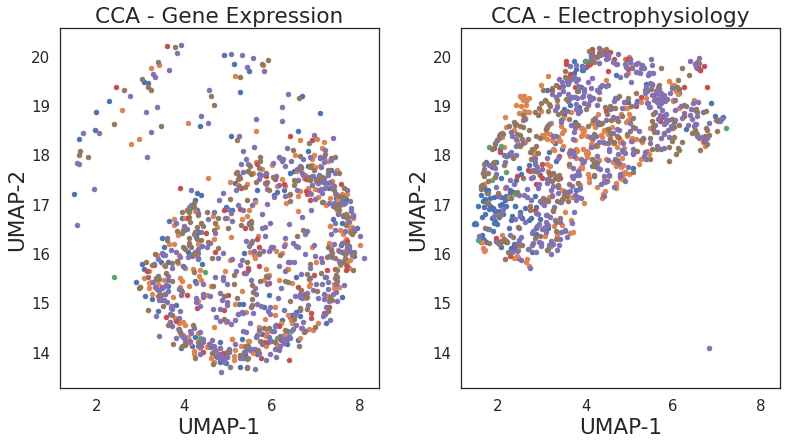

None

KeyboardInterrupt: 

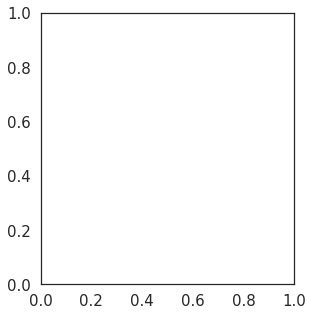

In [102]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names], legend=False)
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
    plt.savefig('./output_figures/' + dataset_name + f'-{n}.png', dpi=300)
    plt.show()

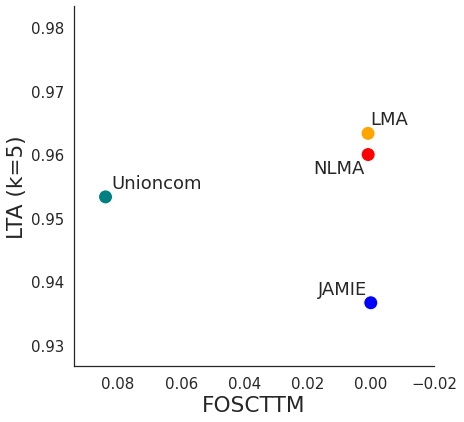

In [376]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, colors=colors)
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Acc.png', dpi=300)

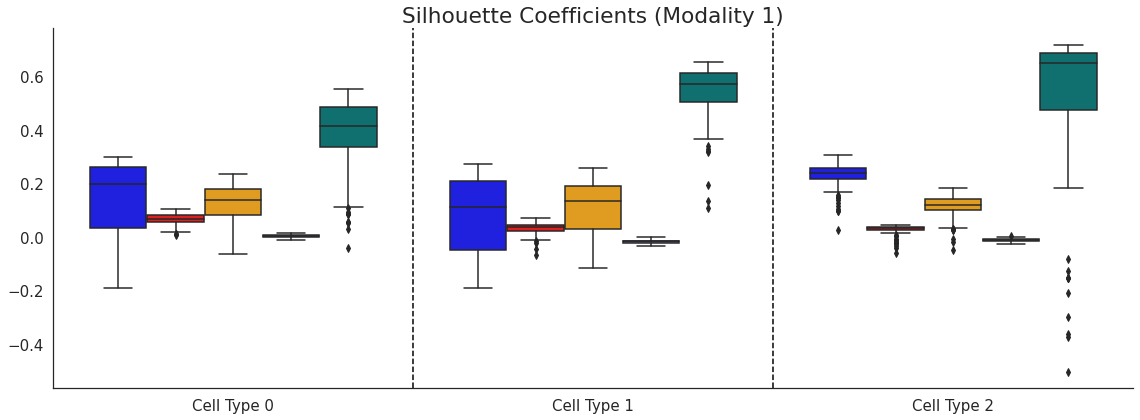

In [377]:
plt.figure(figsize=(15, 5))
plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Sil.png', dpi=300)

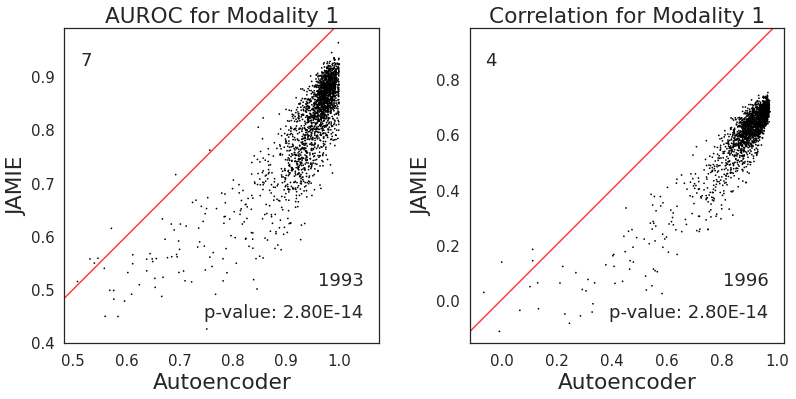

In [234]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png', dpi=300)

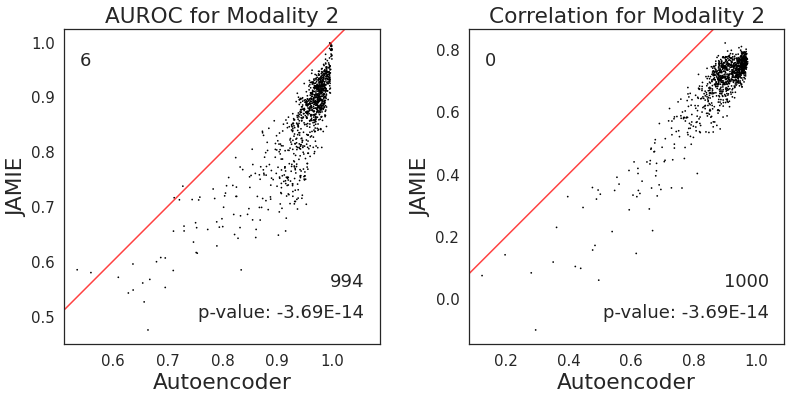

In [235]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png', dpi=300)

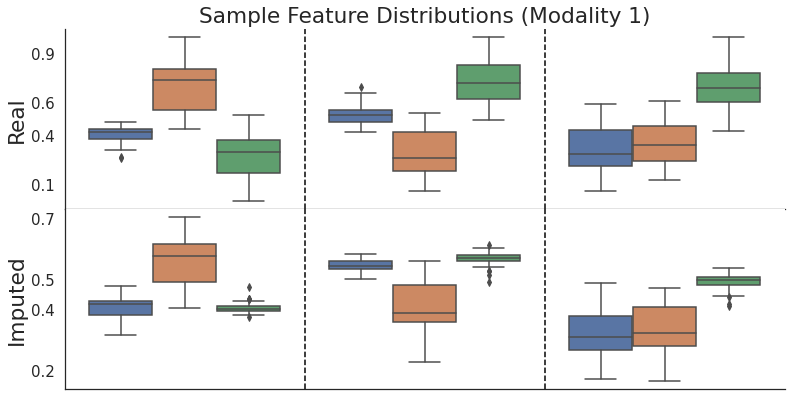

In [236]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png', dpi=300)

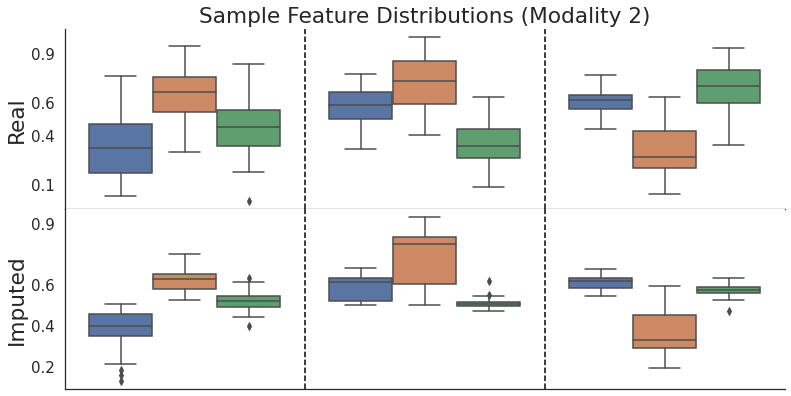

In [237]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png', dpi=300)

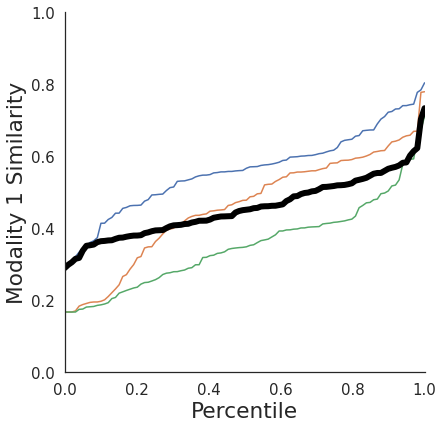

In [238]:
plt.figure(figsize=(10, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png', dpi=300)

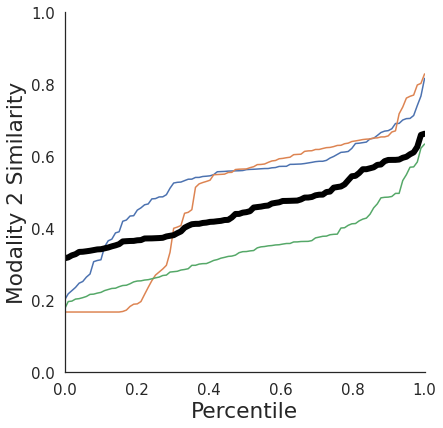

In [239]:
plt.figure(figsize=(10, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png', dpi=300)

# Explanation

In [241]:
# RNA (Place) -> ATAC

In [242]:
mod0, mod1 = 0, 1

In [83]:
from commando.utilities import sort_by_interest

order, interest = sort_by_interest([cm_imputed[mod1], dataset[mod1][test_idx]], limit=10)
order_str = ', '.join([str(n) for n in order[:10]])
order_names_str = ', '.join(features[mod1][order[:10]])
print(f'Top performing features for SHAP:\n{order_names_str}\n{order_str}')
print()
interest_str = ', '.join([str(n) for n in interest[:10]])
interest_names_str = ', '.join(features[mod1][interest[:10]])
print(f'Top interesting features for SHAP:\n{interest_names_str}\n{interest_str}')

invalid value encountered in true_divide
An input array is constant; the correlation coefficient is not defined.


Top performing features for SHAP: 18404, 14412, 31651, 26558, 32408, 22405, 3753, 16231, 32984, 10479
Top interesting features for SHAP: 18404, 9082, 28141, 16220, 27529, 20355, 18578, 11797, 4857, 14345


In [ ]:
import shap

# Subset for runtime
use_subsetting = True
subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
def take_subset(x, do=use_subsetting):
    if not do:
        return x
    if len(x.shape) == 1:
        return x[subset_idx]
    return x[:, subset_idx]
def reverse_subset(x, do=use_subsetting):
    if not do:
        return x
    new_vec = np.concatenate(x.shape[0] * [background], axis=0)
    new_vec[:, subset_idx] = x
    return new_vec

target_feature = interest[0]
current_cm = cm_im
model = lambda x: current_cm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
data = dataset[mod0]
back = background
feature_names = features[mod0]
output_names = features[mod1][target_feature]

# Apply subsetting
data = take_subset(data)
back = take_subset(back)
feature_names = list(take_subset(np.array(feature_names)))

# Explainer
explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names)
shap_values = explainer(data, max_evals=2*data.shape[1]+1)

Permutation explainer:  79%|██████████████████████████████▊        | 789/1000 [04:54<01:22,  2.56it/s]

In [245]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {output_names}')
for n in [output_names]:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n in importance:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target Modality 2 Feature: Feature 605
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 605
Important Modality 1 Features: Feature 808, Feature 70, Feature 1725, Feature 905, Feature 677, Feature 866, Feature 465, Feature 1471, Feature 357, Feature 1265, Feature 79, Feature 1700, Feature 990, Feature 119, Feature 1413, Feature 887, Feature 301, Feature 1477, Feature 515, Feature 203
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 808
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 70
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 1725
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 905
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 677
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 866
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 465
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 1471
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Feature 357
https://www.genecards.org/cgi-bin/ca

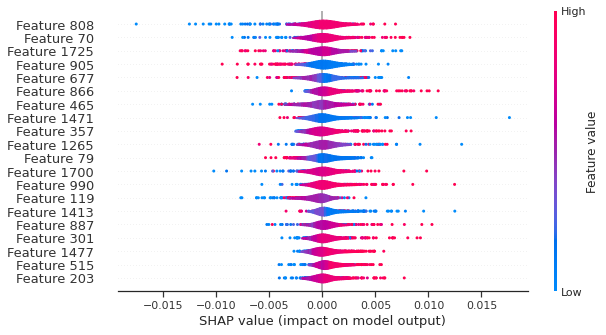

In [246]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=display, plot_size=(9.2, 5), show=False)
plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

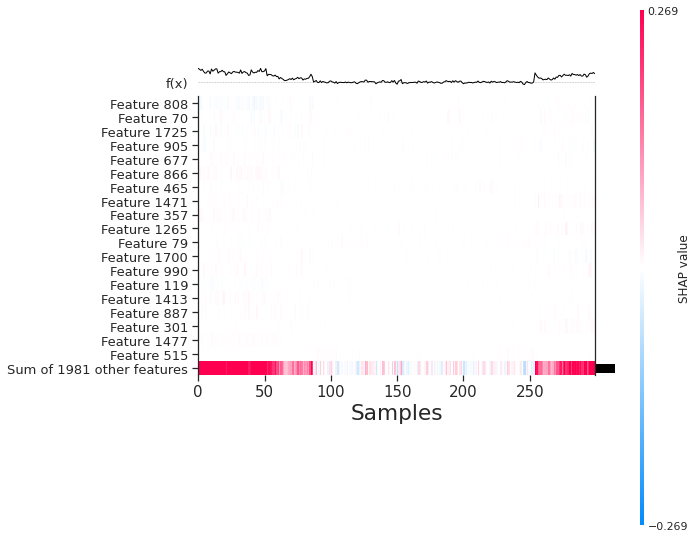

In [247]:
shap.plots.heatmap(shap_values, max_display=display, show=False)
plt.gca().set_xlabel('Samples')
plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

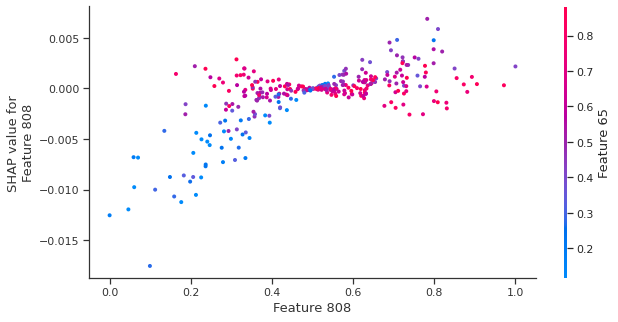

In [248]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

## Interactive

In [ ]:
# # Kernel Explainer
# kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     kshap_values = kexplainer.shap_values(data, nsamples=100)

In [ ]:
# shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
# plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [ ]:
# shap.initjs()
# shap.force_plot(kexplainer.expected_value, kshap_values, data)